# Classification Basics
A basic guide to classification using the sklearn library

## Today's Menu

- Data splits
- Performance metrics
- Basic classification with sklearn
- Multi-class classfication

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split

## Recap: What is the classification process?

- we select features to describe our data
- we label each datapoint based on what we want the model to learn
 this creates our dataset
- we pass this to a model and hope it finds some connections between the features and the labels [training]

When loading our dataset, there is some specific information encoded in the labels that needs to be processed.

1. For each class, each frame has a list of labels. Each item in this list represents one annotator's decision

2. The lables can range from 0-n, where n is the number regions marked with this annotation

- Suppose a file has two annotators. Both annotate the entire file as "dog bark", but annotator 1 also marks a separate region at the beginning as "distant sound of dogs."
For frames in that beginning region, the label for class Dog Bark will be [2, 1]

In [4]:
metadata = pd.read_csv('metadata.csv')
train_files = metadata["filename"]

features_dir = 'audio_features'
labels_dir = 'labels'
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
        'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
        'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
        'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
        'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
        'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
        'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

In [5]:
def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        if(sum(frame_labels) == 0):
            __y.append([0])
        elif(np.count_nonzero(frame_labels) == len(frame_labels)):
             __y.append([1])
        else: #The annotators don't agree on the label
            __y.append([np.random.choice(frame_labels)])
    return __y

In [6]:
import itertools
def read_files(file_names, num_to_read=1000):
    X_train = []
    Y_train = {}
    for c in categories:
        Y_train[c] = []
    for f in file_names[:num_to_read]: #we are not loading the entire dataset due to processing time
        if not os.path.exists(os.path.join(features_dir , f.split('.')[0] + '.npz')):
            continue
        features = np.load(os.path.join(features_dir , f.split('.')[0] + '.npz'))["embeddings"]
        X_train.append(features)
        y = np.load(os.path.join(labels_dir , f.split('.')[0] + '_labels.npz'))
        for c in categories:
            _y = aggregate_labels(y[c])
            Y_train[c].extend(list(itertools.chain.from_iterable(_y)))
    X_train = np.concatenate(X_train)
    return X_train, Y_train


In [7]:
X_train, Y_train = read_files(train_files, 500)

## Task 0: Baseline Classifier
Create a binary classifier that predicts the class that is most frequent in the training dataset

In [8]:
class Baseline_classifier():

    def __init__(self):
        self.majority_class = None

    def fit(self, x_train, y_train):
        '''x_train is a numpy array of features with shape NxD, where N is the number of datapoints and D the feature dimension
        y_train is a list of binary labels in the shape Nx1
        '''
        raise NotImplementedError

    def predict(self, x):
        '''x is a numpy array of features with shape NxD, where N is the number of datapoints and D the feature dimension
        The function should return the predicted binary labels as a numpy array of shape Nx1
        '''
        raise NotImplementedError


In [ ]:
#solution
class Baseline_classifier():

    def __init__(self):
        self.majority_class = None

    def fit(self, x_train, y_train):
        '''x_train is a numpy array of features with shape NxD, where N is the number of datapoints and D the feature dimension
        y_train is a list of binary labels in the shape Nx1
        '''
        self.majority_class =  1 if sum(y_train) > len(y_train) / 2 else 0

    def predict(self, x):
        '''x is a numpy array of features with shape NxD, where N is the number of datapoints and D the feature dimension
        The function should return the predicted binary labels as a numpy array of shape Nx1
        '''
        predictions = np.zeros(x.shape[0]) + self.majority_class
        return predictions

Let's use our baseline classifier to predict whether a sound is wind or not:

In [10]:
wind_x, wind_y = X_train, np.array(Y_train['Wind'])

In [11]:
baseline = Baseline_classifier()
baseline.fit(wind_x, wind_y)

y_train_pred = baseline.predict(wind_x)

train_fraction_correct = np.mean(y_train_pred == wind_y)

print(f"Training Fraction Correct: {train_fraction_correct:.2f}")

Training Fraction Correct: 0.97


This is already a very good accuracy. Does this mean our baseline classifier is actually good?

This problem is caused by data imbalance. We will circle back to this when talking about evaluation metrics. Can you already think of better ways to estimate the model performance?

## Data Split

Would looking into the model's predictions on the whole dataset give us a good estimation of how well it has learned something?
You may remember the KNN classifier from the lecture. Let's see how it performs on the following simple dataset:

In [12]:
# Plotting function
def plot_decision_boundary(knn, X, y, title, highlight_point=None):
    h = 0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(5, 3))
    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', s=100, label='Train data')
    if highlight_point is not None:
        plt.scatter(highlight_point[0][0], highlight_point[0][1], color='gold', edgecolor='k',
                    marker='*', s=250, label='Test point (not in train)')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.show()

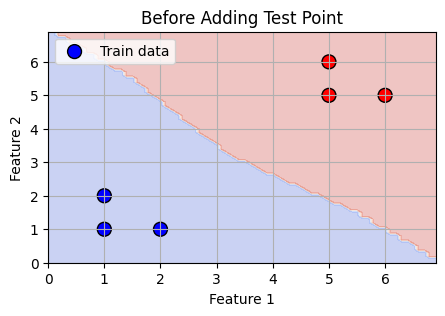

In [13]:
X_train = np.array([
    [1, 1], [1, 2], [2, 1],        # Class 0
    [5, 5], [5, 6], [6, 5]         # Class 1
])
y_train = np.array([0, 0, 0, 1, 1, 1])

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

plot_decision_boundary(knn, X_train, y_train, "Before Adding Test Point")

The classes seem to be perfectly separated. Assuming the model works perfectly, we deploy it in a real world setting, and the first new data comes in:

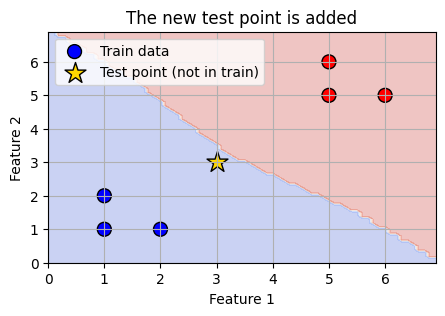

In [14]:
test_point = np.array([[3, 3]])    
true_label = np.array([1])

pred_before = knn.predict(test_point)

plot_decision_boundary(knn, X_train, y_train, "The new test point is added", highlight_point=test_point)

So, the predictions of the model may not be as good as we expect. To get a more realistic estimation of how a model is performing, we can put a part of the dataset aside and look at how the model performs on this set. The sklearn library has a function for this [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

Let's repeat the experiment on our own dataset for class wind:

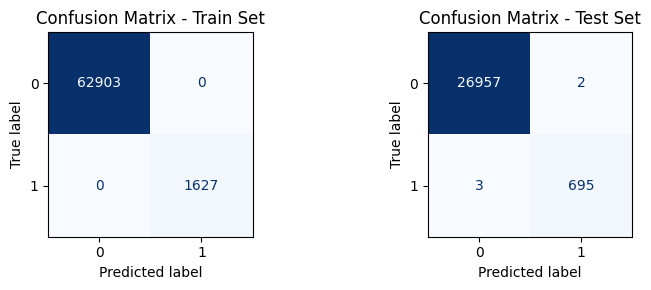

In [15]:
# Split data
X_train_wind, X_test_wind, y_train_wind, y_test_wind = train_test_split(
    wind_x, wind_y, test_size=0.3, random_state=42
)

# Train model
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_wind, y_train_wind)

# Predictions
y_train_pred = knn.predict(X_train_wind)
y_test_pred = knn.predict(X_test_wind)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # Side by side, smaller overall size

# Train confusion matrix
cm_train = confusion_matrix(y_train_wind, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=knn.classes_)
disp_train.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix - Train Set")

# Test confusion matrix
cm_test = confusion_matrix(y_test_wind, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=knn.classes_)
disp_test.plot(cmap='Blues', ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix - Test Set")

plt.tight_layout()
plt.show()


Assuming that the distribution of our data matches that of the "real data", this will usually give us a better estimation of how the model performs. But this is still not quite accurate for a dataset similar to ours, due to a problem referred to as data leakage.

Data leakage occurs when a model has access to information during training that would not be available at prediction time — often leading to overly optimistic performance. Why is this problem relevant to us?

train_test_split splits the data randomly. If you apply it directly on the frame level, frames from the same original audio file may end up in both the training and test sets.

Since consecutive frames are highly correlated (they come from the same source), this violates the assumption that the test set is unseen data. As a result:

The model might "memorize" patterns from specific files and the evaluation metrics will be overly optimistic and misleading.

## taks 1:
How do we prevent data leakage in our dataset?

In [ ]:
raise NotImplementedError

In [ ]:
#solution
train_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()[:int(len(metadata)*0.8)]
test_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()[int(len(metadata)*0.8):]

X_train, Y_train = read_files(train_files, 500)
X_test, Y_test = read_files(test_files, 100)

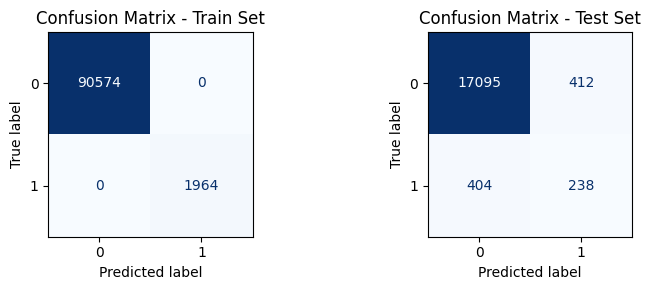

In [18]:
wind_x_train, wind_y_train = X_train, np.array(Y_train['Wind'])
wind_x_test, wind_y_test = X_test, np.array(Y_test['Wind'])

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(wind_x_train, wind_y_train)

y_train_pred = knn.predict(wind_x_train)
y_test_pred = knn.predict(wind_x_test)


# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # Side by side, smaller overall size

# Train confusion matrix
cm_train = confusion_matrix(wind_y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=knn.classes_)
disp_train.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix - Train Set")

# Test confusion matrix
cm_test = confusion_matrix(wind_y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=knn.classes_)
disp_test.plot(cmap='Blues', ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix - Test Set")

plt.tight_layout()
plt.show()


We have tried two models so far. Often when training a classifier we consider different model classes, and each with a set of hyper parameters.  

Could we use the performance on the test set to choose the best classifier?

No, you should not use the test set to choose the best classifier or tune hyperparameters — that would lead to data leakage and overestimate your model’s true performance.

The test set is our unseen data, and if we select the model class and hyperparameters based on that, then the model has indirectly “seen” the test data and the evaluation becomes optimistic and less reliable. To avoid this, we put aside another section of data as the validation set.

In [19]:
train_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()[:int(len(metadata)*0.7)]
validation_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()[int(len(metadata)*0.7):int(len(metadata)*0.9)]
test_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()[int(len(metadata)*0.9):]
#So final split: 70% train, 20% val, 10% test


## Performance Metrics

| Metric                   | Description                                                 | When It's Useful                                                       |
| ------------------------ | ----------------------------------------------------------- | ---------------------------------------------------------------------- |
| **Accuracy**             | % of correct predictions `(TP + TN) / Total`                | Simple, but **misleading with imbalanced data**                        |
| **Precision**            | How many predicted positives were correct: `TP / (TP + FP)` | Important when **false positives** are costly (e.g., spam filters)     |
| **Recall (Sensitivity)** | How many actual positives were caught: `TP / (TP + FN)`     | Critical when **false negatives** are costly (e.g., medical diagnosis) |
| **F1 Score**             | Harmonic mean of precision and recall                       | Good **balance** when classes are imbalanced                           |
| **ROC AUC**              | Measures ranking ability over all thresholds                | Good for **probabilistic models**; not sensitive to threshold          |
| **PR AUC**               | Area under Precision-Recall curve                           | Better than ROC AUC for **imbalanced data**                            |


In [20]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, balanced_accuracy_score
)

# y_true: ground truth labels
# y_pred: predicted class labels (e.g., 0 or 1)
# y_scores: predicted probabilities or decision function scores

accuracy      = accuracy_score(wind_y_test, y_test_pred)
precision     = precision_score(wind_y_test, y_test_pred, zero_division=0)
recall        = recall_score(wind_y_test, y_test_pred)
f1            = f1_score(wind_y_test, y_test_pred)
roc_auc       = roc_auc_score(wind_y_test, y_test_pred)
pr_auc        = average_precision_score(wind_y_test, y_test_pred)
weighted_acc  = balanced_accuracy_score(wind_y_test, y_test_pred)

print(f"Accuracy:         {accuracy:.3f}")
print(f"Weighted Accuracy:{weighted_acc:.3f}")
print(f"Precision:        {precision:.3f}")
print(f"Recall:           {recall:.3f}")
print(f"F1 Score:         {f1:.3f}")
print(f"ROC AUC:          {roc_auc:.3f}")
print(f"PR AUC:           {pr_auc:.3f}")


Accuracy:         0.955
Weighted Accuracy:0.674
Precision:        0.366
Recall:           0.371
F1 Score:         0.368
ROC AUC:          0.674
PR AUC:           0.158


## Training Classifiers

Now we can move on to training classifiers. Let's start be training a very simple Decision Tree.  
A **Decision Tree** is a model that splits data by asking feature-based questions, forming a tree structure.  

In [21]:
X_train, Y_train = read_files(train_files, 500)
X_test, Y_test = read_files(test_files, 50)
X_val, Y_val = read_files(validation_files, 100)

#subsampling the training data to reduce run time
sample_size = 1000
indices = np.random.choice(len(X_train), size=sample_size, replace=False)

X_train = X_train[indices]
for c in categories:
    Y_train[c] = [Y_train[c][i] for i in indices]


wind_x_train, wind_y_train = X_train, np.array(Y_train['Wind'])
wind_x_test, wind_y_test = X_test, np.array(Y_test['Wind'])
wind_x_val, wind_y_val = X_val, np.array(Y_val['Wind'])

In [22]:
from sklearn.tree import DecisionTreeClassifier

# Define the model
dt = DecisionTreeClassifier(random_state=42)

The DT classifier has several patameters we can experiment with. Let's pick a few to explore

In [23]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
best_score = 0
best_params = None
best_model = None

In [24]:
# Generate all combinations of hyperparameters
for max_depth, min_samples_split, criterion in itertools.product(
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['criterion']
):
    model = DecisionTreeClassifier(max_depth=max_depth,min_samples_split=min_samples_split,criterion=criterion,random_state=42)
    model.fit(wind_x_train, wind_y_train)

    y_val_pred = model.predict(wind_x_val)
    score = balanced_accuracy_score(wind_y_val, y_val_pred)
    print(f"Params: max_depth={max_depth}, min_samples_split={min_samples_split}, criterion={criterion} --> Accuracy: {score:.4f}")

    if score > best_score:
        best_score = score
        best_params = {
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'criterion': criterion
        }
        best_model = model
print("\nBest Parameters:")
print(best_params)
print(f"Best Validation Accuracy: {best_score:.4f}")


Params: max_depth=3, min_samples_split=2, criterion=gini --> Accuracy: 0.4919
Params: max_depth=3, min_samples_split=2, criterion=entropy --> Accuracy: 0.8796
Params: max_depth=3, min_samples_split=5, criterion=gini --> Accuracy: 0.4919
Params: max_depth=3, min_samples_split=5, criterion=entropy --> Accuracy: 0.8796
Params: max_depth=3, min_samples_split=10, criterion=gini --> Accuracy: 0.4919
Params: max_depth=3, min_samples_split=10, criterion=entropy --> Accuracy: 0.8796
Params: max_depth=5, min_samples_split=2, criterion=gini --> Accuracy: 0.4905
Params: max_depth=5, min_samples_split=2, criterion=entropy --> Accuracy: 0.8128
Params: max_depth=5, min_samples_split=5, criterion=gini --> Accuracy: 0.4905
Params: max_depth=5, min_samples_split=5, criterion=entropy --> Accuracy: 0.8128
Params: max_depth=5, min_samples_split=10, criterion=gini --> Accuracy: 0.4905
Params: max_depth=5, min_samples_split=10, criterion=entropy --> Accuracy: 0.8130
Params: max_depth=10, min_samples_split=2,

## Multi-Label vs Multi-Class classfication

The classifiers we looked into were all **binary** classifiers, and simply distinguish if a datapoint belongs in a class or not. Among non-binary classification problems, two common sets of classes are **Multi-Label Classification** and **Multi-Class Classification**.

- Multi-Class: We have n possible classes, where each instance belongs to exactly one class.
- Multi-Label: We have n possible classes, and each instance can belong to multiple classes (or none).  

Which description fits our task better?

In our dataset we have a set of sound events that can happen simultaniously and in the same audio frame. This turns our problem into a multi-label classification problem. One simple was of performing this type of classification is to have one binary classfier per class, working independantly. Can you think of a better solution?

In [25]:
selected_classes = {'Alarm', 'Wind', 'Dog Bark'}

y_train = np.array([Y_train[cls] for cls in selected_classes]).T
y_val = np.array([Y_val[cls] for cls in selected_classes]).T
y_test = np.array([Y_test[cls] for cls in selected_classes]).T

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier

X = X_train
Y = y_train

base_clf = DecisionTreeClassifier()

br_clf = MultiOutputClassifier(base_clf)

br_clf.fit(X, Y)

Y_pred = br_clf.predict(X_val)

In [27]:
from sklearn.metrics import balanced_accuracy_score
import numpy as np

n_labels = y_val.shape[1]
balanced_accuracies = []

for i in range(n_labels):
    score = balanced_accuracy_score(y_val[:, i], Y_pred[:, i])
    balanced_accuracies.append(score)

# Macro-average across labels
balanced_accuracy_macro = np.mean(balanced_accuracies)

print("Macro-Averaged Balanced Accuracy:", balanced_accuracy_macro)

Macro-Averaged Balanced Accuracy: 0.666563965864554


/home/tara/miniconda3/envs/ai2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


## Task 2: 
train a [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for multi-label classification and report your results. Take a look at the documentation and choose hyperparameters that you think would work best.

In [ ]:
raise NotImplementedError

In [ ]:
#solution

X = X_train
Y = y_train

base_clf = RandomForestClassifier()

br_clf = MultiOutputClassifier(base_clf)

br_clf.fit(X, Y)

Y_pred = br_clf.predict(X_val)